# DBSCAN. Практическая работа

## Цель практической работы

Научиться строить модели кластеризации с помощью метода DBSCAN.

## Что входит в работу


- Загрузите данные и проведите разведочный анализ.
- Предположите оптимальное количество кластеров.
- Постройте модель кластеризации DBSCAN.
- Определите оптимальное количество и структуру кластеров.
- Интерпретируйте полученные результаты.

## Что оценивается 

1. Выполнены все задания.
2. Сделаны выводы по результатам разведочного анализа данных.
3. Объяснены выбранные гиперпараметры модели кластеризации.
4. Сделаны выводы о количестве и структуре кластеров.
5. Сделаны выводы по результатам кластеризации.

# Задача

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды. 
* AFDP — перепад давления на воздушном фильтре. 
* GTEP — давление на выходе из газовой турбины. 
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины. 
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа. 
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('gt_2015.csv')

In [3]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [4]:
# очень недобные названия
col_names = dict()
for col in df.columns:
    col_names[col] = col.lower()[3:] if 'mnt' in col.lower() else (col.lower()[3:] if 'num' in col.lower() else  col.lower())
df = df.rename(columns=col_names)

In [5]:
for col in df.columns:

    res = stats.shapiro(df[col])
#     print(res[1] > 0.05)
    print(col,' - not normal dist' if res.pvalue <= 0.05  else '- normal dist')

at  - not normal dist
ap  - not normal dist
ah  - not normal dist
afdp  - not normal dist
gtep  - not normal dist
tit  - not normal dist
tat  - not normal dist
tey  - not normal dist
cdp  - not normal dist
co  - not normal dist
nox  - not normal dist


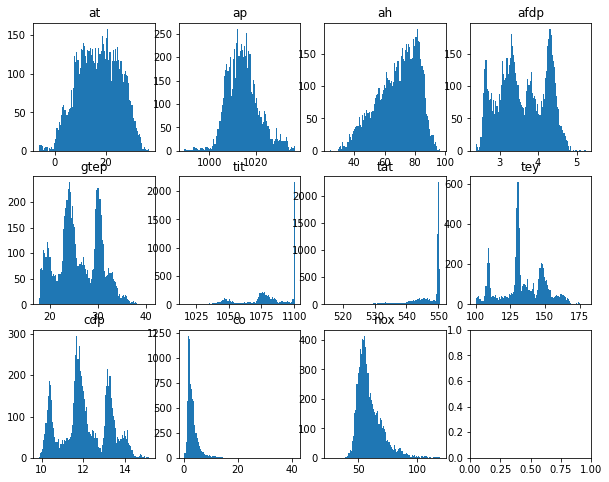

In [6]:
ax = plt.subplots(3, (len(df.columns) // 3 + 1), figsize=(10,8), )[1]
i = 0
k = 0
counter = 0
for col in df.columns:
    if counter == 4:
        i +=1
        counter = 0
        k = 0
    ax[i][k].hist(df[col], bins=100)
    ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1


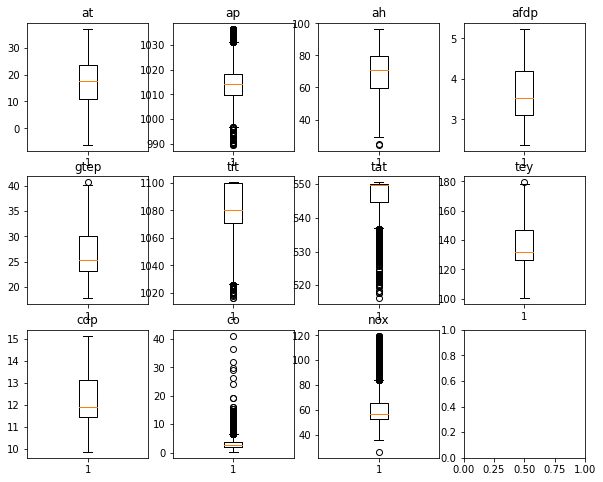

In [7]:
ax = plt.subplots(3, (len(df.columns) // 3 + 1), figsize=(10,8), )[1]
i = 0
k = 0
counter = 0
for col in df.columns:
    if  col == 'dt_customer':
        continue
    if counter == 4:
        i +=1
        counter = 0
        k = 0
    ax[i][k].boxplot(df[col])
    ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1

In [8]:
# выбросов немало, кажется
# перетащим пару полезных функций из прошлых модулей

In [9]:
def calculate_iqr_boundaries(series):
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25

    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [10]:
def bounds_f(df):
    bounds = []
    bounds_d = dict()
    for col in df.columns:
#         if col == 'gender':
#             continue
#         iter_name = f'{col}'
        bounds_d[col] = calculate_iqr_boundaries(df[col])
#         bounds.append(calculate_iqr_boundaries(df[col]))
#     for i in range(len(df.columns)):
#         if x_train.columns[i] == 'gender':
#             continue
#         bounds_d[df.columns[i]] = bounds[i]
    return bounds_d


In [11]:
possible_cl_count_leads = {
    'gtep': 'давление на выходе из газовой турбины',
    'cdp': 'давление нагнетания компрессора',
    'tey': 'энергоотдача турбины',
    'afdp': 'перепад давления на воздушном фильтре',
}

In [12]:
df[possible_cl_count_leads.keys()]

,gtep,cdp,tey,afdp
0,20.116,10.799,116.27,2.5304
1,18.584,10.347,109.18,2.3937
2,22.264,11.256,125.88,2.7789
3,23.358,11.702,132.21,2.8170
4,23.483,11.737,133.58,2.8377
...,...,...,...,...
7379,19.087,10.411,109.08,3.1661
7380,19.016,10.344,108.79,3.1923
7381,18.857,10.462,107.81,3.3128
7382,23.563,11.771,131.41,3.9831


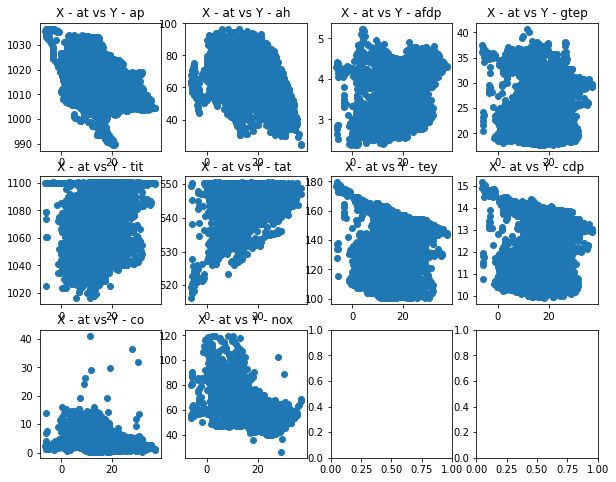

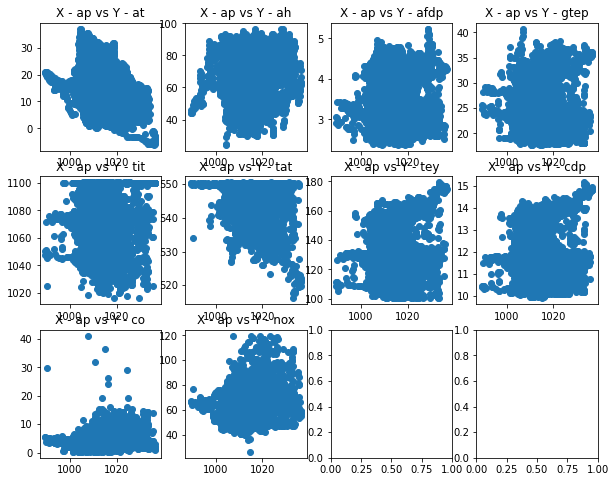

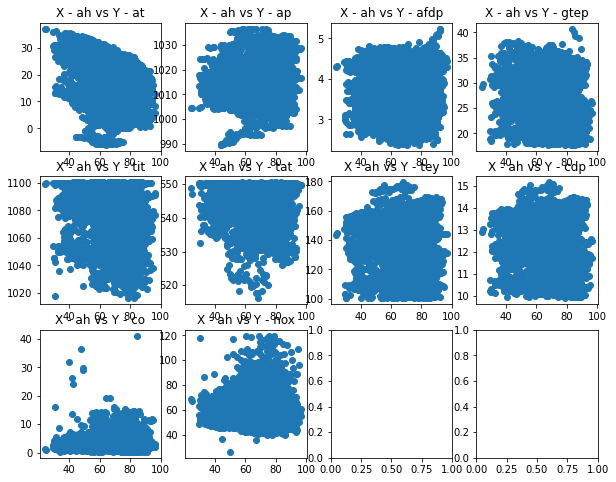

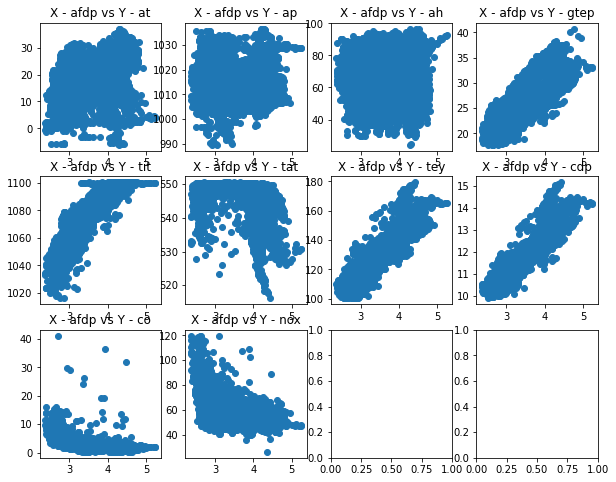

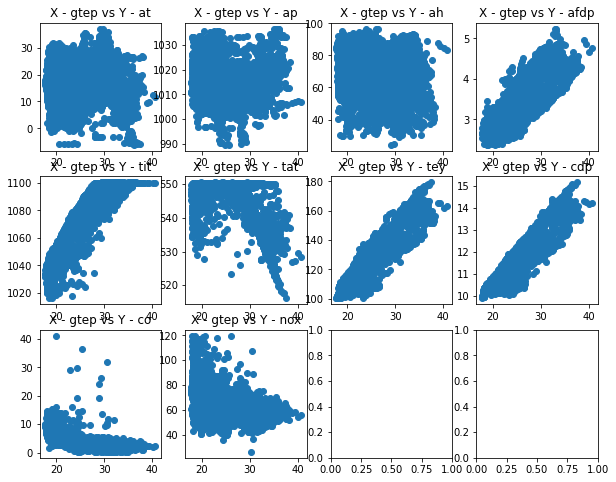

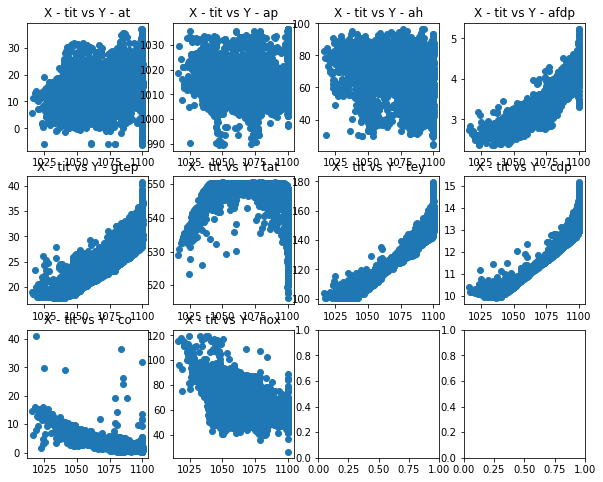

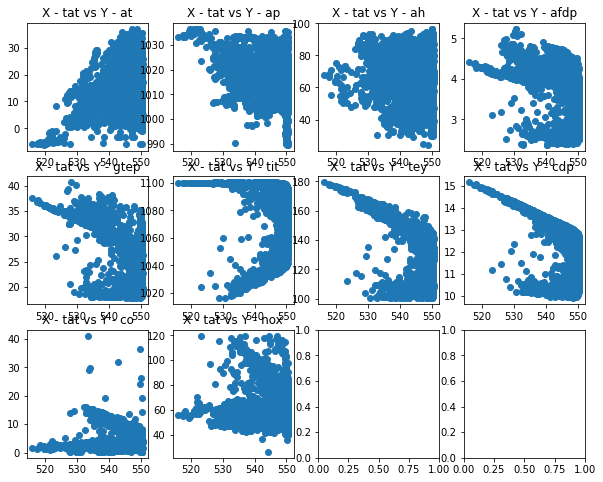

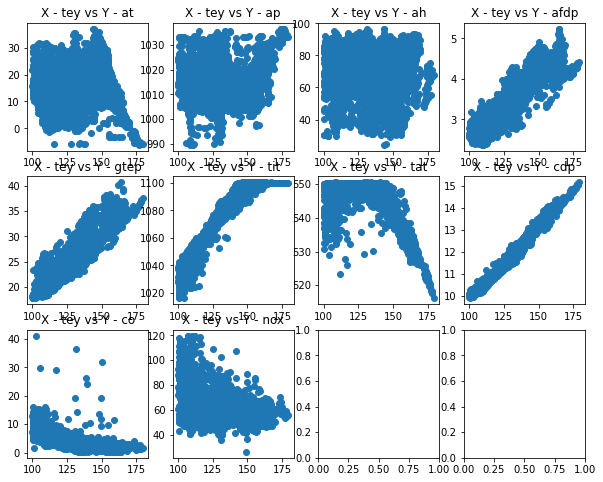

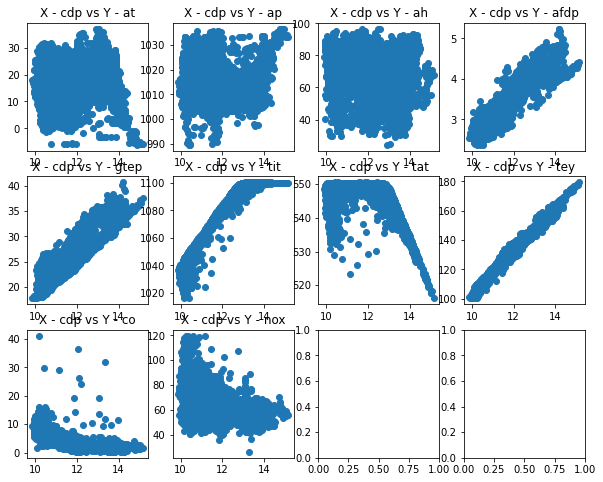

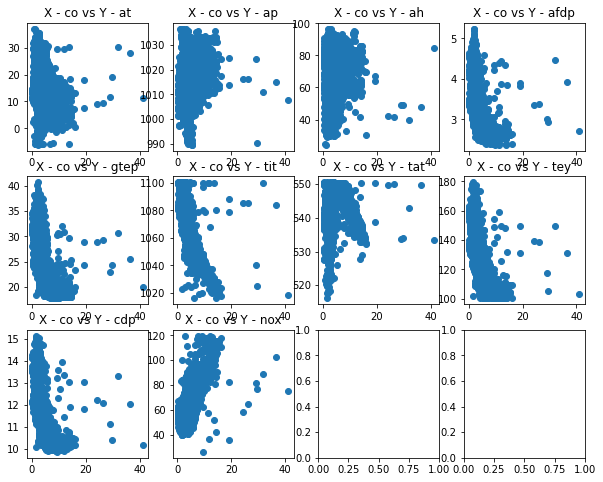

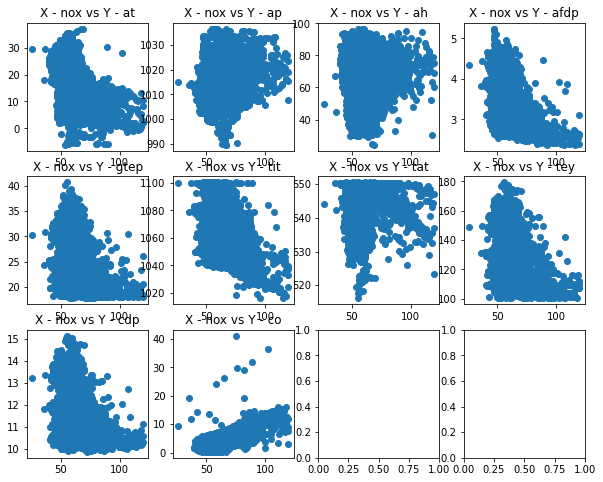

In [11]:
for col_main in df.columns:
    num_cols = []
    for col in df.columns:
        if col == col_main:
            continue
        else:
            num_cols.append(col)
            
    ax = plt.subplots(3, (len(df.columns) // 3 + 1), figsize=(10,8), )[1]
    i = 0
    k = 0
    counter = 0
    for col in num_cols:
        if  col == 'dt_customer':
            continue
        if counter == 4:
            i +=1
            counter = 0
            k = 0
        ax[i][k].scatter(df[col_main], df[col])
        ax[i][k].set_title(f'X - {col_main} vs Y - {col}')#, rotation=30)
        k += 1
        counter += 1

<AxesSubplot:>

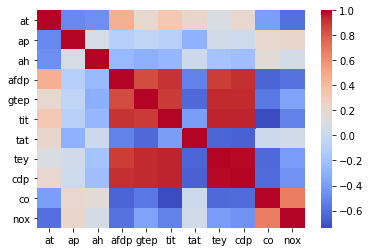

In [12]:
sns.heatmap(df.corr(), cmap='coolwarm')

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

In [13]:
possible_cl_count_leads

NameError: name 'possible_cl_count_leads' is not defined

In [ ]:
ax = plt.subplots(2, 2, figsize=(5,6), )[1]
i = 0
k = 0
counter = 0
for col in df[possible_cl_count_leads.keys()].columns:
    if counter == 2:
        i +=1
        counter = 0
        k = 0
    ax[i][k].hist(df[col], bins=100)
    ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1


In [ ]:
# ну я могу в принципе, думаю, понять связь между давлением компрессора и давлением на выходе из 
# турбины - опять же, это подтверждается графиками
# предположим, турбины работают в трех режимах основных "усердия"
# отсюда же связь с энергоотдачей
# пока напрашивается 3 кластера

# правда 4 отчетливых "спайка" в колонке перепадов давления как то не особо встраиваются в эту теорию - думаю,
# возьмем, как вариант еще 4 кластера - думаю, мы можем себе позволить отработать 2 версии\

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

In [ ]:
# ячейки ниже - финальный вариант - до этого было много гридсерчей на разных версиях датасета и все время 
# получалось либо 2 кластера (большой и 20 выбросов) либо 2к+ - в итоге решение крылось в более гранульном 
# переборе вариантов и отказе от гридсерча - он же по cv, кажется, валидирует - а цикл в 5 раз быстрее
# еще хотел от безысходности через tsne сделать, прогнать там на уменьшенной размерности и прилепить ярлыки к исходному сету - но 
# до такой порнографии не дошло - кстати - а это вообще "законно" было бы?) в теории же отношения внустри 
# кластеров должны сохраниться, но я не уверен, что это сработало бы, учитывая, что модель не могла нащупать 
# кластеры как таковые
# кластеры продолжили не хотеть делиться, любопытства ради все же попоробовал уменьшить размерность и потом 
# уже поделить - совсем плохой вариант

In [14]:
# для начала отскалируем 
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [15]:
model = DBSCAN(eps=0.7, min_samples=10)
model.fit(df_scaled)

DBSCAN(eps=0.7, min_samples=10)

In [16]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [17]:
df_scaled['labels'] = 0

In [18]:

models = dict()
counter = 0
df_scaled['labels'] = 0
flag = False
for i in np.arange(0.1, 1.1, 0.1):
    for k in np.arange(1, 24, 2):
        df_scaled = df_scaled.drop('labels', axis=1)
        
        model = DBSCAN(eps=i, min_samples=k)
        model.fit(df_scaled)
        df_scaled['labels'] = model.labels_
        if 3 <= len(df_scaled['labels'].unique()) < 10:
            print('sil score ', silhouette_score(df_scaled, df_scaled['labels']))
            print(f'eps is {i}, ms is {k}')
            print(f'len labels.unique is,', len(df_scaled['labels'].unique()))
            flag = True
            models[f'model_{counter}'] = {'model': model,
                                          'info': {'clusters': len(df_scaled['labels'].unique()),
                                                  'eps': i,
                                                   'min_samp': k,
                                                   'sil_core': silhouette_score(df_scaled, df_scaled['labels']),
                                                  },
                                         }
            counter += 1
if not flag:
    print('nnnnnope')

sil score  0.4358480394190609
eps is 0.2, ms is 5
len labels.unique is, 9
sil score  0.4204481634355108
eps is 0.2, ms is 7
len labels.unique is, 7
sil score  0.4065134935157912
eps is 0.2, ms is 9
len labels.unique is, 3
sil score  0.406130100421502
eps is 0.2, ms is 11
len labels.unique is, 3
sil score  0.4621200041526557
eps is 0.2, ms is 13
len labels.unique is, 4
sil score  0.4614995633088699
eps is 0.2, ms is 15
len labels.unique is, 4
sil score  0.4594730149042968
eps is 0.2, ms is 17
len labels.unique is, 4
sil score  0.45727798347429216
eps is 0.2, ms is 19
len labels.unique is, 4
sil score  0.46186147319587195
eps is 0.2, ms is 21
len labels.unique is, 3
sil score  0.4624435107362705
eps is 0.2, ms is 23
len labels.unique is, 3
sil score  0.43130960862324985
eps is 0.30000000000000004, ms is 3
len labels.unique is, 3
sil score  0.4296575167057237
eps is 0.30000000000000004, ms is 5
len labels.unique is, 3
sil score  0.42879922953152566
eps is 0.30000000000000004, ms is 7
len 

In [19]:
for model in models.keys():    
    best_model = models[model]['model']
    #         print(type(best_model))
    df_scaled['labels'] = best_model.labels_
    print(df_scaled.labels.value_counts())
    print('***'*4)

 0    7211
-1     104
 7      26
 3      11
 4       7
 5       7
 1       6
 2       6
 6       6
Name: labels, dtype: int64
************
 0    7203
-1     127
 5      26
 1       8
 2       7
 3       7
 4       6
Name: labels, dtype: int64
************
 0    7184
-1     174
 1      26
Name: labels, dtype: int64
************
 0    7174
-1     184
 1      26
Name: labels, dtype: int64
************
 0    7127
-1     194
 1      37
 2      26
Name: labels, dtype: int64
************
 0    7121
-1     201
 1      37
 2      25
Name: labels, dtype: int64
************
 0    7110
-1     219
 1      37
 2      18
Name: labels, dtype: int64
************
 0    7091
-1     245
 1      37
 2      11
Name: labels, dtype: int64
************
 0    7051
-1     297
 1      36
Name: labels, dtype: int64
************
 0    7022
-1     327
 1      35
Name: labels, dtype: int64
************
 0    7357
-1      19
 1       8
Name: labels, dtype: int64
************
 0    7353
-1      23
 1       8
Name: labe

flag = False
max_score = 0
best_model = None
for model in models.keys():
    if max_score < models[model]['info']['sil_core']:
        max_score = models[model]['info']['sil_core']
        best_model = models[model]['model']
#         print(type(best_model))
df_scaled['labels'] = best_model.labels_

best_model = models['model_3']['model']
#         print(type(best_model))
df_scaled['labels'] = best_model.labels_
df_scaled.labels.value_counts()

In [ ]:
models = dict()
counter = 0
df_scaled['labels'] = 0
flag = False

for pxt in range(len(np.arange(5,96,10))):
    tsne = TSNE(n_components=2, perplexity=np.arange(5,101,5)[pxt])
    df_emb = tsne.fit_transform(df_scaled.drop('labels', axis=1))
    data = pd.DataFrame(df_emb)
    data['labels'] = 0


    for i in np.arange(0.1, 1.1, 0.1):
        for k in np.arange(1, 24, 2):
            data = data.drop('labels', axis=1)

            model = DBSCAN(eps=i, min_samples=k)
            model.fit(data)
            data['labels'] = model.labels_
            if 4 <= len(data['labels'].unique()) < 7:
                print('sil score ', silhouette_score(data, data['labels']))
                print(f'eps is {i}, ms is {k}')
                print(f'len labels.unique is,', len(data['labels'].unique()))
                flag = True
                models[f'model_{counter}'] = {'model': model,
                                              'info': {'clusters': len(data['labels'].unique()),
                                                      'eps': i,
                                                       'min_samp': k,
                                                       'sil_core': silhouette_score(data, data['labels']),
                                                       'pxt': pxt,
                                                      },
                                             }
                counter += 1
    if not flag:
        print('nnnnnope')

In [83]:
# скор как будто бы неплохой, в сравнении с тем, на чем мы остановились в видео, но 824 кластера это, мне кажется, 
# перебор - попробуем вернуться назад, избавиться от выбросов/аномалий и посмотрим, что нам скажет гридсерч на этот раз

In [20]:
df_no_outliers = df.copy()
bounds = bounds_f(df_no_outliers)

for col in df_no_outliers:
    df_no_outliers[col] = df_no_outliers[col].apply(lambda x: bounds[col][0] if x < bounds[col][0] else ( bounds[col][1] if x > bounds[col][1] else x))

    
# для начала отскалируем 
scaler = MinMaxScaler()

df_no_outliers_scaled = pd.DataFrame(scaler.fit_transform(df_no_outliers), columns=df_no_outliers.columns)

df_no_outliers_scaled['labels'] = 0



models_no_outs_scaled = dict()
counter = 0
flag = False
for i in np.arange(0.1, 1.1, 0.1):
    for k in np.arange(1, 24, 2):
        df_no_outliers_scaled = df_no_outliers_scaled.drop('labels', axis=1)
        
        model = DBSCAN(eps=i, min_samples=k)
        model.fit(df_no_outliers_scaled)
        df_no_outliers_scaled['labels'] = model.labels_
        if 3 <= len(df_no_outliers_scaled['labels'].unique()) < 10:
            print('sil score ', silhouette_score(df_no_outliers_scaled, df_no_outliers_scaled['labels']))
            print(f'eps is {i}, ms is {k}')
            print(f'len labels.unique is,', len(df_no_outliers_scaled['labels'].unique()))
            flag = True
            models_no_outs_scaled[f'model_{counter}'] = {'model': model,
                                          'info': {'clusters': len(df_no_outliers_scaled['labels'].unique()),
                                                  'eps': i,
                                                   'min_samp': k,
                                                   'sil_core': silhouette_score(df_no_outliers_scaled, df_no_outliers_scaled['labels']),
                                                  },
                                         }
            counter += 1
if not flag:
    print('nnnnnope')
    



sil score  0.329934331191371
eps is 0.2, ms is 5
len labels.unique is, 9
sil score  0.32906405305279873
eps is 0.2, ms is 7
len labels.unique is, 7
sil score  0.33824487733916014
eps is 0.2, ms is 9
len labels.unique is, 8
sil score  0.3360091694508901
eps is 0.2, ms is 11
len labels.unique is, 8
sil score  0.3375803993971996
eps is 0.2, ms is 13
len labels.unique is, 8
sil score  0.32905876820341906
eps is 0.2, ms is 15
len labels.unique is, 4
sil score  0.35453074589261646
eps is 0.2, ms is 17
len labels.unique is, 3
sil score  0.36436052330904395
eps is 0.2, ms is 19
len labels.unique is, 4
sil score  0.36446068572760226
eps is 0.2, ms is 21
len labels.unique is, 4
sil score  0.3628294704783998
eps is 0.2, ms is 23
len labels.unique is, 4
sil score  0.35639815028728944
eps is 0.30000000000000004, ms is 3
len labels.unique is, 4
sil score  0.3506785030565065
eps is 0.4, ms is 3
len labels.unique is, 5
sil score  0.3558340175150274
eps is 0.4, ms is 5
len labels.unique is, 3
sil score

In [24]:
counter = 0
for model in models_no_outs_scaled.keys():    
    best_model = models_no_outs_scaled[model]['model']
    #         print(type(best_model))
    df_no_outliers_scaled['labels'] = best_model.labels_
    print(df_no_outliers_scaled.labels.value_counts())
    print(counter, model)
    counter += 1
    print('***'*4)

 0    6955
-1     355
 7      24
 6      23
 1       6
 2       6
 4       5
 5       5
 3       5
Name: labels, dtype: int64
0 model_0
************
 0    6869
-1     443
 5      24
 4      23
 2      10
 3       8
 1       7
Name: labels, dtype: int64
1 model_1
************
 0    6765
-1     524
 6      24
 5      22
 4      16
 2      15
 3      15
 1       3
Name: labels, dtype: int64
2 model_2
************
 0    6665
-1     619
 6      23
 5      22
 4      16
 2      15
 1      14
 3      10
Name: labels, dtype: int64
3 model_3
************
 0    6599
-1     696
 5      22
 6      16
 2      15
 3      15
 1      14
 4       7
Name: labels, dtype: int64
4 model_4
************
 0    6538
-1     815
 1      16
 2      15
Name: labels, dtype: int64
5 model_5
************
 0    6444
-1     903
 1      37
Name: labels, dtype: int64
6 model_6
************
 0    6327
-1     972
 2      56
 1      29
Name: labels, dtype: int64
7 model_7
************
 0    6279
-1    1028
 2      48
 1    

{'model': DBSCAN(eps=0.2, min_samples=23),
 'info': {'clusters': 4,
  'eps': 0.2,
  'min_samp': 23,
  'sil_core': 0.3628294704783998}}

In [28]:
tsne = TSNE(n_components=2, perplexity=25)
df_emb = tsne.fit_transform(df_scaled.drop('labels', axis=1))
data = pd.DataFrame(df_emb)
data['labels'] = 0
data = data.drop('labels', axis=1)
model = models_no_outs_scaled['model_9']['model']
data['labels'] = model.labels_

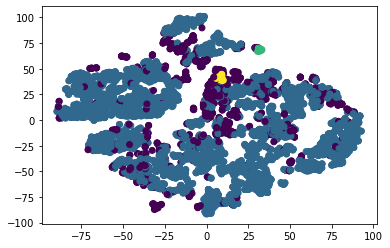

In [34]:
plt.scatter(data[0], data[1], c=data.labels)

IndexError: index 2 is out of bounds for axis 0 with size 2

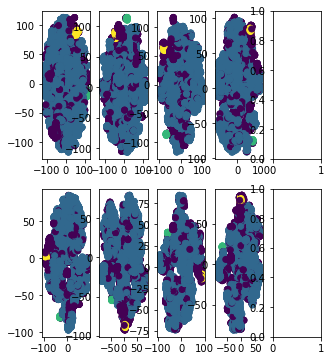

In [37]:
ax = plt.subplots(2, 5, figsize=(5,6), )[1]
i = 0
k = 0
counter = 0


for pxt in range(len(np.arange(5,96,10))):
    tsne = TSNE(n_components=2, perplexity=np.arange(5,51,5)[pxt])
    df_emb = tsne.fit_transform(df_scaled.drop('labels', axis=1))
    data = pd.DataFrame(df_emb)
    data['labels'] = 0
    data = data.drop('labels', axis=1)
    model = models_no_outs_scaled['model_9']['model']
    data['labels'] = model.labels_
    if counter == 4:
        i +=1
        counter = 0
        k = 0
    ax[i][k].scatter(data[0], data[1], c=data.labels)
#     ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1



    
df_no_outliers = df.copy()
bounds = bounds_f(df_no_outliers)

for col in df_no_outliers:
    df_no_outliers[col] = df_no_outliers[col].apply(lambda x: bounds[col][0] if x < bounds[col][0] else ( bounds[col][1] if x > bounds[col][1] else x))

    
# для начала отскалируем 
# scaler = MinMaxScaler()

# df_no_outliers_scaled = pd.DataFrame(scaler.fit_transform(df_no_outliers), columns=df_no_outliers.columns)

# df_no_outliers_scaled['labels'] = 0

df_no_outliers['labels'] = 0

models_no_outs = dict()
counter = 0
flag = False
for i in np.arange(0.1, 1.1, 0.1):
    for k in np.arange(1, 24, 2):
        df_no_outliers = df_no_outliers.drop('labels', axis=1)
        
        model = DBSCAN(eps=i, min_samples=k)
        model.fit(df_no_outliers)
        df_no_outliers['labels'] = model.labels_
        if 3 <= len(df_no_outliers['labels'].unique()) < 10:
            print('sil score ', silhouette_score(df_no_outliers, df_no_outliers['labels']))
            print(f'eps is {i}, ms is {k}')
            print(f'len labels.unique is,', len(df_no_outliers['labels'].unique()))
            flag = True
            models_no_outs[f'model_{counter}'] = {'model': model,
                                          'info': {'clusters': len(df_no_outliers['labels'].unique()),
                                                  'eps': i,
                                                   'min_samp': k,
                                                   'sil_core': silhouette_score(df_no_outliers, df_no_outliers['labels']),
                                                  },
                                         }
            counter += 1
if not flag:
    print('nnnnnope')

for model in models_no_outs.keys():    
    best_model = models_no_outs[model]['model']
    #         print(type(best_model))
    df_no_outliers['labels'] = best_model.labels_
    print(df_no_outliers.labels.value_counts())
    print('***'*4)

In [35]:
# еще хуже....
# ладно, попробуем не скалировать

eps = np.arange(0.1, 1.1, 0.2)
min_samples = np.arange(8, 23, 7)
param_grid = {
    'eps': eps,
    'min_samples': min_samples,
}

model = DBSCAN()

grid_search = GridSearchCV(model, param_grid, scoring=silhouette_score)
grid_search.fit(df_no_outliers_scaled)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Use the best model for clustering
labels = best_model.fit_predict(df_no_outliers_scaled)
# print("Cluster Labels:", labels)
df_no_outliers_scaled['labels'] = labels
print(df_no_outliers_scaled.labels.value_counts())
# print("best Sil score:", silhouette_score(df_no_outliers, df_no_outliers['labels']))

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных. 

In [ ]:
так же - вторая колонка в описании названа PT вместо АР - опечатка, ясное дело - если дойдут руки поправить 

**Как отправить работу на проверку**

Скачайте файл с работой в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint на вкладке меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.
